In [1]:
import os
import sys
import ast
import json
import math
import shutil
import random
import pickle
import imageio
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
root_dir = '/data/jupiter/li.yu/data'
dataset = 'halohitchhiker_for_dust_analysis'
csv = os.path.join(root_dir, dataset, 'annotations.csv')
converters = {}
df = pd.read_csv(csv, converters=converters)
df.shape

/home/li.yu/anaconda3/envs/pytorchlightning/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3437: DtypeWarning: Columns (0,1,36,37,38,39,40,42,43,44,45,46,47,48,49,50,51,55,63,72,75,92,94,95,96,97,127,128,140,158,159,161,171,173) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


(200000, 175)

In [3]:
# load seg prediction
pred_dir = f'/data/jupiter/li.yu/exps/driveable_terrain_model/v100_11cls_nodrop_dustasdust_0724/{dataset}'
pred_df = pd.read_csv(os.path.join(pred_dir, 'output.csv'))
print(pred_df.shape)
pred_df['id'] = pred_df['unique_id']
# merge with df
df = df.merge(pred_df.drop(columns=["unique_id", "camera_location"]), on='id')
print(df.shape)

(200000, 24)
(200000, 197)


### Get dust df and show examples

In [5]:
# get dust df
dust_df = df[df['n_pred_dust-debris_pixels'] > 0.1]
print(dust_df.shape)
dust_df.groupby('operation_time').size()

(6509, 197)


operation_time
dawn_dusk     360
daytime      1324
nightime     4823
unknown         2
dtype: int64

In [10]:
# get dust df at different time
dust_df_sub = dust_df[dust_df.operation_time == 'nightime']
dust_df_sub.shape

(4823, 197)

In [ ]:
def plot_image(img, figsize=(12, 6)):
    plt.figure(figsize=figsize)
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    plt.show()

653023873ab6dc09410766a5 T14 2023-10-10T00:34:49.539000 0.208544921875


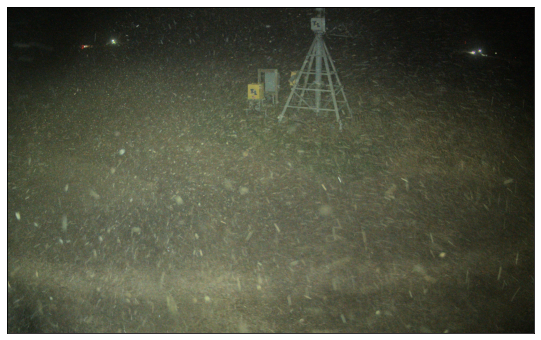

65385fa85d7de481a2627aea T07 2023-10-13T01:39:18.070000 0.215234375


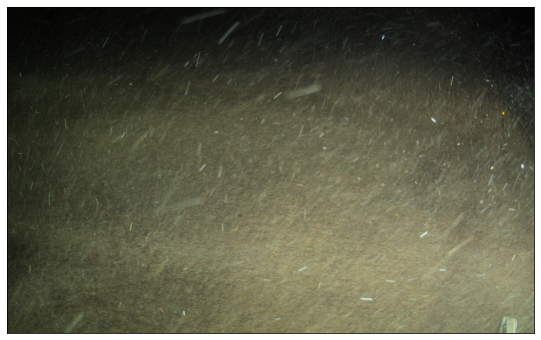

In [14]:
sub_df = dust_df_sub.sample(2)
for i, row in sub_df.iterrows():
    print(row.id, row.camera_location, row.collected_on, row['n_pred_dust-debris_pixels'])
    image = imageio.imread(os.path.join(root_dir, dataset, row.artifact_debayeredrgb_0_save_path))
    plot_image(image)

### Dust occurrence analysis for day

In [41]:
df_day = df[df.operation_time == 'daytime']
dust_df_day = dust_df[dust_df.operation_time == 'daytime']
df_day.shape, dust_df_day.shape

<ipython-input-41-e07223cd925e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_day['collected_day_hour'] = df_day['collected_on'].apply(lambda t: t[:13])


((167141, 198), (1324, 197))

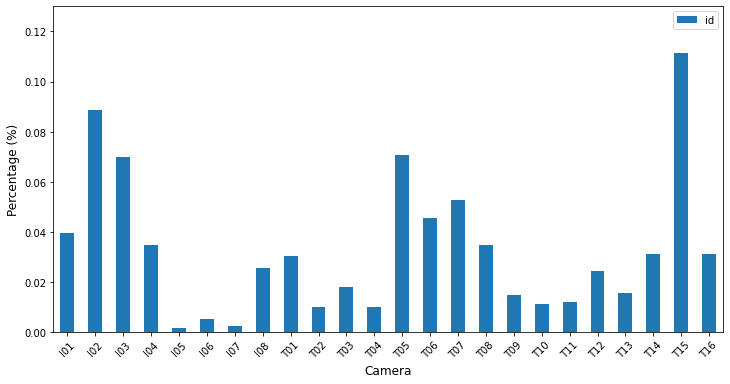

In [77]:
# dust distribution over cameras
cam_g = dust_df_day[['id', 'camera_location']].groupby('camera_location').count() / len(df_day) * 100

cam_g.plot.bar(figsize=(12,6))
plt.xticks(rotation=45, ha='center')
plt.ylim(0.0, 0.13)
plt.xlabel("Camera", fontsize=12)
plt.ylabel("Percentage (%)", fontsize=12)
plt.show()

In [63]:
# dust distribution over days/hours
def get_image_count_by_day_hour(df):
    # truncate time to day_hour
    df['collected_day_hour'] = df['collected_on'].apply(lambda t: t[:13])
    print(df.iloc[0].collected_day_hour, df.iloc[-1].collected_day_hour)
    
    # groupby day hour
    day_hour_g = df[['id', 'collected_day_hour']].groupby('collected_day_hour').count().reset_index()
    print(day_hour_g.shape)

    return day_hour_g

In [71]:
# get image count per day_hour
day_hour_g = get_image_count_by_day_hour(df_day)
day_hour_g.rename(columns={"id": "Image count"}, inplace=True)

# get dust image count per day_hour
dust_day_hour_g = get_image_count_by_day_hour(dust_df_day)
dust_day_hour_g.rename(columns={"id": "Dust image count"}, inplace=True)

# combine two groups
day_hour_g = day_hour_g.merge(dust_day_hour_g, on='collected_day_hour', how='left')
day_hour_g["Dust image count"].fillna(0, inplace=True)
day_hour_g["Dust image percentage"] = day_hour_g["Dust image count"] / day_hour_g["Image count"]
day_hour_g.shape

2023-09-12T19 2023-11-01T19
(374, 2)
2023-09-28T22 2023-10-24T17
(158, 2)


<ipython-input-63-eddf2d7a5a8e>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['collected_day_hour'] = df['collected_on'].apply(lambda t: t[:13])


(374, 4)

In [72]:
day_hour_g.sample(5)

,collected_day_hour,Image count,Dust image count,Dust image percentage
8,2023-09-15T14,210,0.0,0.000000
114,2023-10-01T22,465,26.0,0.055914
73,2023-09-25T22,109,1.0,0.009174
166,2023-10-09T16,1206,4.0,0.003317
20,2023-09-19T00,1,0.0,0.000000


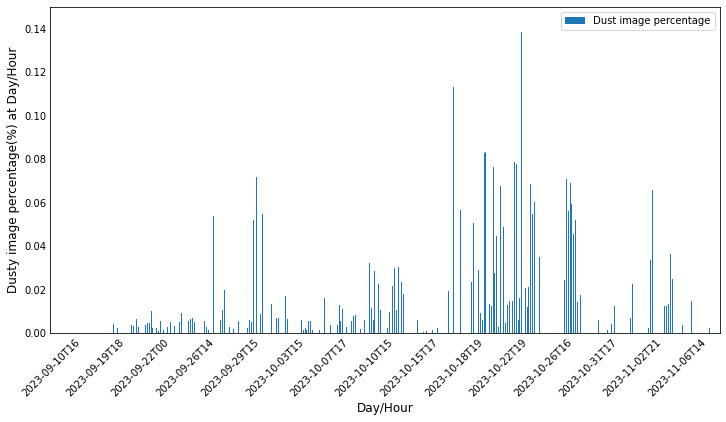

In [81]:
ax = day_hour_g.plot.bar(x='collected_day_hour', y='Dust image percentage', figsize=(12,6))
for i, t in enumerate(ax.get_xticklabels()):
    if (i % 25) != 0:
        t.set_visible(False)
ax.tick_params(axis='both', which='both', length=0)
plt.xticks(rotation=45, ha='center')
plt.ylim(0.0, 0.15)
plt.xlabel("Day/Hour", fontsize=12)
plt.ylabel("Dusty image percentage(%) at Day/Hour", fontsize=12)
plt.show()